# 0

In [1]:
from google.colab import drive
import os, numpy as np
drive.mount("/content/drive", force_remount=False)

BASE_DIR = "/content/drive/MyDrive/grunitech-project3-cyberbullying"
PROCESSED_DIR = f"{BASE_DIR}/data/processed"

embeddings = np.load(f"{PROCESSED_DIR}/minilm_embeddings.npy")
confidences = np.load(f"{PROCESSED_DIR}/confidences.npy")
strong_bully = np.load(f"{PROCESSED_DIR}/strong_bully_idx.npy")
strong_safe  = np.load(f"{PROCESSED_DIR}/strong_safe_idx.npy")
ambiguous    = np.load(f"{PROCESSED_DIR}/ambiguous_idx.npy")

print("Embeddings:", embeddings.shape)


Mounted at /content/drive
Embeddings: (34020, 384)


# 1

In [2]:
!pip install -q torch numpy matplotlib tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt


# 2

In [3]:
class SyntheticClusterDataset(Dataset):
    def __init__(
        self,
        embeddings,
        confidences,
        bully_idx,
        safe_idx,
        ambig_idx,
        cluster_size=64,
        n_clusters=8000,
        ambig_fraction=0.4,
    ):
        self.emb = embeddings
        self.conf = confidences
        self.bully = np.where(bully_idx)[0]
        self.safe = np.where(safe_idx)[0]
        self.ambig = np.where(ambig_idx)[0]
        self.cluster_size = cluster_size
        self.n_clusters = n_clusters
        self.ambig_fraction = ambig_fraction

    def __len__(self):
        return self.n_clusters

    def __getitem__(self, idx):
        N = self.cluster_size
        n_ambig = int(N * self.ambig_fraction)
        n_core = N - n_ambig

        # ratio controls composition of the "core"
        bully_ratio = np.random.uniform(0, 1)
        n_bully = int(n_core * bully_ratio)
        n_safe = n_core - n_bully

        bully_samples = np.random.choice(self.bully, n_bully, replace=True)
        safe_samples = np.random.choice(self.safe, n_safe, replace=True)
        ambig_samples = np.random.choice(self.ambig, n_ambig, replace=True)

        indices = np.concatenate([bully_samples, safe_samples, ambig_samples])
        np.random.shuffle(indices)

        X = self.emb[indices]          # [N, D]
        conf = self.conf[indices]      # [N]

        # Smooth label: intensity
        y = float(conf.mean())

        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# 3

In [4]:
dataset = SyntheticClusterDataset(
    embeddings, confidences,
    strong_bully, strong_safe, ambiguous,
    cluster_size=64,
    n_clusters=8000,
    ambig_fraction=0.4
)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


# 4

In [8]:
class MAB(nn.Module):
    # Multihead Attention Block
    def __init__(self, dim_Q, dim_KV, dim_out, num_heads=4):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=dim_out, num_heads=num_heads, batch_first=True)
        self.fc_q = nn.Linear(dim_Q, dim_out)
        self.fc_k = nn.Linear(dim_KV, dim_out)
        self.fc_v = nn.Linear(dim_KV, dim_out)

        self.ln1 = nn.LayerNorm(dim_out)
        self.ln2 = nn.LayerNorm(dim_out)

        self.ff = nn.Sequential(
            nn.Linear(dim_out, dim_out),
            nn.ReLU(),
            nn.Linear(dim_out, dim_out)
        )

    def forward(self, Q, KV):
        Q_ = self.fc_q(Q)
        K_ = self.fc_k(KV)
        V_ = self.fc_v(KV)

        H, _ = self.mha(Q_, K_, V_)
        H = self.ln1(H + Q_)
        O = self.ln2(H + self.ff(H))
        return O


class ISAB(nn.Module):
    # Induced Set Attention Block (corrected)
    def __init__(self, dim_in, dim_out, num_heads=4, num_inducing=16):
        super().__init__()

        self.proj = nn.Linear(dim_in, dim_out)
        self.I = nn.Parameter(torch.randn(1, num_inducing, dim_out))

        # Both MABs now operate in dim_out space
        self.mab1 = MAB(
            dim_Q=dim_out,
            dim_KV=dim_out,
            dim_out=dim_out,
            num_heads=num_heads
        )

        self.mab2 = MAB(
            dim_Q=dim_out,
            dim_KV=dim_out,
            dim_out=dim_out,
            num_heads=num_heads
        )

    def forward(self, X):
        # X: [B, N, dim_in]
        Xp = self.proj(X)             # [B, N, dim_out]
        B = Xp.size(0)
        I = self.I.expand(B, -1, -1)  # [B, m, dim_out]

        H = self.mab1(I, Xp)          # [B, m, dim_out]
        O = self.mab2(Xp, H)          # [B, N, dim_out]
        return O


class PMA(nn.Module):
    # Pooling by Multihead Attention
    def __init__(self, dim, num_heads=4, num_seeds=1):
        super().__init__()
        self.S = nn.Parameter(torch.randn(1, num_seeds, dim))
        self.mab = MAB(dim_Q=dim, dim_KV=dim, dim_out=dim, num_heads=num_heads)

    def forward(self, X):
        B = X.size(0)
        S = self.S.expand(B, -1, -1)
        return self.mab(S, X)  # [B, num_seeds, dim]


# 5 Set Transformer Regressor

In [9]:
class SetTransformerRegressor(nn.Module):
    def __init__(self, dim_in=384, dim=256, num_heads=4, num_inducing=16):
        super().__init__()
        self.enc1 = ISAB(dim_in=dim_in, dim_out=dim, num_heads=num_heads, num_inducing=num_inducing)
        self.enc2 = ISAB(dim_in=dim, dim_out=dim, num_heads=num_heads, num_inducing=num_inducing)
        self.pool = PMA(dim=dim, num_heads=num_heads, num_seeds=1)

        self.head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # outputs in [0,1] since label is mean confidence
        )

    def forward(self, X):
        # X: [B, N, D]
        H = self.enc1(X)
        H = self.enc2(H)
        P = self.pool(H).squeeze(1)  # [B, dim]
        y = self.head(P).squeeze(-1) # [B]
        return y


# 6 Train

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SetTransformerRegressor().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.SmoothL1Loss()

EPOCHS = 8

for epoch in range(EPOCHS):
    model.train()
    total = 0.0

    for X, y in tqdm(loader):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        total += loss.item()

    print(f"Epoch {epoch+1} | loss = {total/len(loader):.6f}")


100%|██████████| 250/250 [00:06<00:00, 38.18it/s]


Epoch 1 | loss = 0.013322


100%|██████████| 250/250 [00:05<00:00, 42.61it/s]


Epoch 2 | loss = 0.013234


100%|██████████| 250/250 [00:05<00:00, 42.51it/s]


Epoch 3 | loss = 0.013063


100%|██████████| 250/250 [00:05<00:00, 42.73it/s]


Epoch 4 | loss = 0.013005


100%|██████████| 250/250 [00:05<00:00, 42.97it/s]


Epoch 5 | loss = 0.013158


100%|██████████| 250/250 [00:05<00:00, 42.84it/s]


Epoch 6 | loss = 0.013157


100%|██████████| 250/250 [00:05<00:00, 43.00it/s]


Epoch 7 | loss = 0.012971


100%|██████████| 250/250 [00:05<00:00, 42.65it/s]

Epoch 8 | loss = 0.013146


# 7 Plotting

## 7.a. Label histogram vs prediction histogram

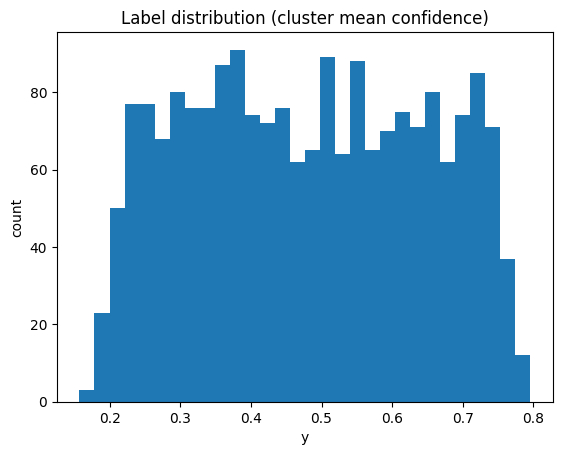

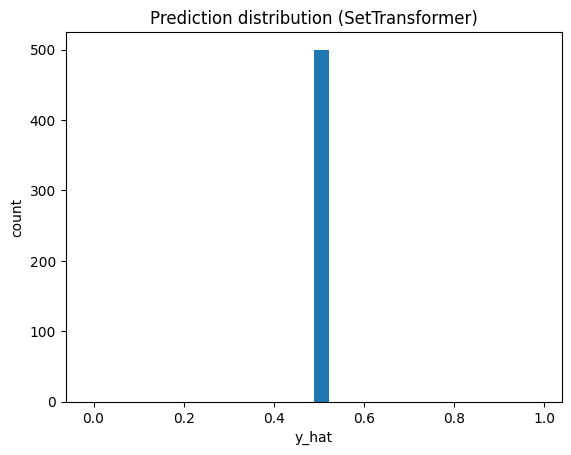

In [11]:
# sample labels from dataset
ys = [dataset[i][1].item() for i in range(2000)]

plt.hist(ys, bins=30)
plt.title("Label distribution (cluster mean confidence)")
plt.xlabel("y")
plt.ylabel("count")
plt.show()

# sample predictions
model.eval()
preds = []
with torch.no_grad():
    for i in range(500):
        X, _ = dataset[i]
        X = X.unsqueeze(0).to(device)
        preds.append(model(X).item())

plt.hist(preds, bins=30)
plt.title("Prediction distribution (SetTransformer)")
plt.xlabel("y_hat")
plt.ylabel("count")
plt.show()


## 7.b. Calibration scatter (best plot)

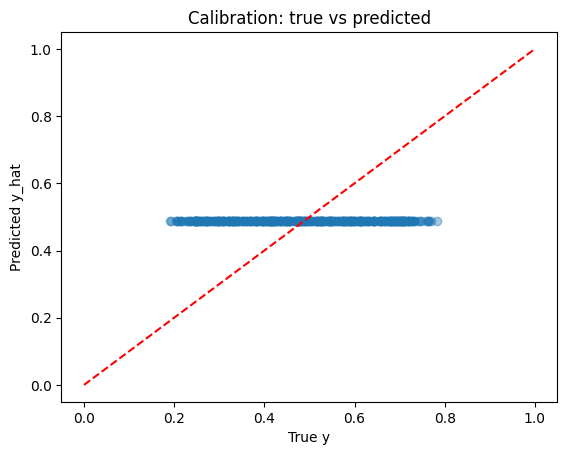

In [12]:
model.eval()
ys = []
y_hats = []

with torch.no_grad():
    for i in range(400):
        X, y = dataset[i]
        X = X.unsqueeze(0).to(device)
        ys.append(y.item())
        y_hats.append(model(X).item())

plt.scatter(ys, y_hats, alpha=0.4)
plt.plot([0,1], [0,1], "r--")
plt.xlabel("True y")
plt.ylabel("Predicted y_hat")
plt.title("Calibration: true vs predicted")
plt.show()


## 7.c. Monotonicity / bucket check (updated)

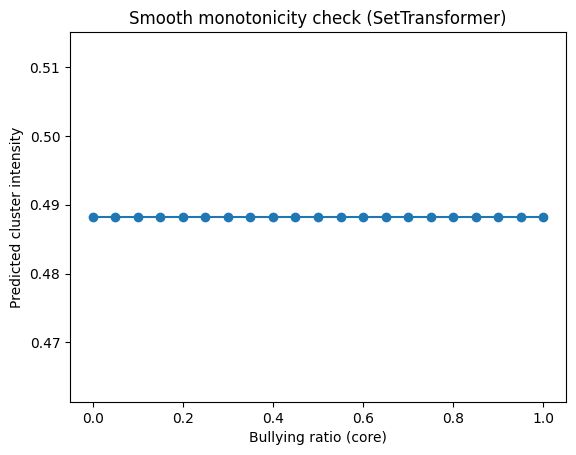

In [13]:
def test_cluster_ratio(ratio, N=64, ambig_fraction=0.4):
    n_ambig = int(N * ambig_fraction)
    n_core = N - n_ambig
    n_bully = int(n_core * ratio)
    n_safe = n_core - n_bully

    bully_samples = np.random.choice(np.where(strong_bully)[0], n_bully, replace=True)
    safe_samples = np.random.choice(np.where(strong_safe)[0], n_safe, replace=True)
    ambig_samples = np.random.choice(np.where(ambiguous)[0], n_ambig, replace=True)

    idx = np.concatenate([bully_samples, safe_samples, ambig_samples])
    X = torch.tensor(embeddings[idx], dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        return model(X).item()

ratios = np.linspace(0, 1, 21)
scores = [test_cluster_ratio(r) for r in ratios]

plt.plot(ratios, scores, marker="o")
plt.xlabel("Bullying ratio (core)")
plt.ylabel("Predicted cluster intensity")
plt.title("Smooth monotonicity check (SetTransformer)")
plt.show()


# 8 Save the model

In [ ]:
MODEL_DIR = f"{BASE_DIR}/models/set_transformer_cluster"
os.makedirs(MODEL_DIR, exist_ok=True)

torch.save(model.state_dict(), f"{MODEL_DIR}/model.pt")
print("✅ Saved:", f"{MODEL_DIR}/model.pt")
